In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
from tensorflow import set_random_seed
from keras import regularizers
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential,Model  # The model building API we'll be using
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten, ZeroPadding2D,Convolution2D # The layers we'll need for our first models

In [4]:
def load_data(path):
    path = path + "\\"
    X = []
    Y = []
    for img_name in os.listdir(path):
        img_path = path + img_name
        img = cv2.imread(img_path, -1)
        X.append(img)
        label = img_name.split("_")[0]
        Y.append(label)
    X = np.array(X)
    Y = np.array(Y)
    
    #label encoding to convert string to number
    label_enc = LabelEncoder()
    label_enc.fit(Y)
    classes = label_enc.transform(Y).reshape(-1, 1)
    #one hot encoding to convert number to binary vector
    one_hot_enc = OneHotEncoder(sparse=False)
    one_hot_enc.fit(classes)
    one_hot_classes = one_hot_enc.transform(classes)
    
    return X, one_hot_classes

In [5]:
def normalize_images(X):
    X = X/255
    return X

In [6]:
def split_dataset(X, Y, rate=0.2, shuffle=True):
    if shuffle:
        np.random.seed(10)
        np.random.shuffle(X)
        np.random.seed(10)
        np.random.shuffle(Y)
    X_train = X[:int(X.shape[0]*(1-rate))]
    Y_train = Y[:int(Y.shape[0]*(1-rate))]
    X_test = X[int(X.shape[0]*(1-rate)):]
    Y_test = Y[int(Y.shape[0]*(1-rate)):]
    #print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)
    return X_train, Y_train, X_test, Y_test

Build a standard CNN model without any optimization

In [7]:
def build_model3(input_shape, num_classes):
    model = Sequential()
    # We defined the size of the images earlier, and will use that to define the input_shape
    # We will also define our kernel/filter to be 5x5, or process 25 pixels at a time
    # The strides parameter dictates how the filter passes over our images, in this case 1x and 1y at a time
    model.add(Conv2D(16, kernel_size=(3, 3), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
    # Next we add a Pooling layer, it's 2D because we are working a static image
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # After our set of convolutions, we flatten the image to create a ANN
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    
    # The softmax function will need to know how many classes we've defined
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return(model)

Build a CNN model. We add bath normalization and dropout layers on the dense layers to prevent overfitting

In [8]:
def build_model(input_shape, num_classes):
    model = Sequential()
    # We defined the size of the images earlier, and will use that to define the input_shape
    # We will also define our kernel/filter to be 5x5, or process 25 pixels at a time
    # The strides parameter dictates how the filter passes over our images, in this case 1x and 1y at a time
    model.add(Conv2D(16, kernel_size=(3, 3), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
    # Next we add a Pooling layer, it's 2D because we are working a static image
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # After our set of convolutions, we flatten the image to create a ANN
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(BatchNormalization())
   
    
    # The softmax function will need to know how many classes we've defined
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return(model)
    

Build a CNN model. This is our best model. In this model, we add a batch normalization layer after each convolution layer and use L2 regularization in each convolution layer and dense layer to reduce the overfitting

In [9]:
def build_model2(input_shape, num_classes):
    model = Sequential()
    # We defined the size of the images earlier, and will use that to define the input_shape
    # We will also define our kernel/filter to be 5x5, or process 25 pixels at a time
    # The strides parameter dictates how the filter passes over our images, in this case 1x and 1y at a time
    model.add(Conv2D(16, kernel_size=(3, 3), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape, kernel_regularizer=regularizers.l2(0.0001)))
    # Next we add a Pooling layer, it's 2D because we are working a static image
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
   
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # After our set of convolutions, we flatten the image to create a ANN
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization())
   
    
    # The softmax function will need to know how many classes we've defined
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return(model)
    

In [10]:
def show_image(X, Y, number):
    #plot images and show the labels
    for i in range(number):
        index = np.argmax(Y[i])
        plt.imshow(X[i], cmap='gray')
        plt.title(label_dict[index])
        plt.show()

(532, 75, 75)
(532, 4)


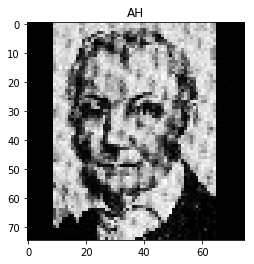

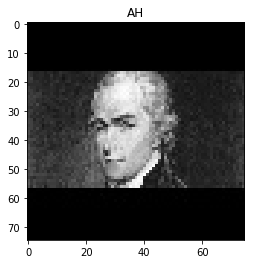

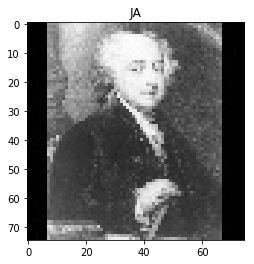

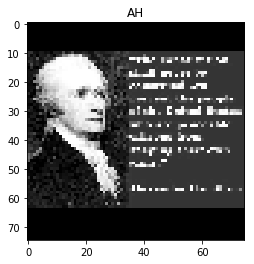

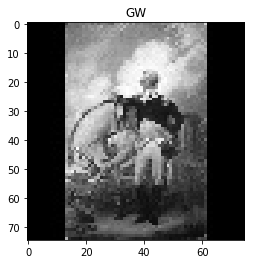

(75, 75, 1) 4


In [12]:
label_dict = {
 0: 'AH',
 1: 'GW',
 2: 'JA',
 3: 'TJ',
}

X, Y = load_data("F:\\study\\Neural_network\\homework\\Final_Project_Dataset")
print(X.shape)
print(Y.shape)

X = normalize_images(X)

X_train, Y_train, X_test, Y_test = split_dataset(X, Y, rate = 0.2, shuffle = True)

#plot 5 images and show the labels
show_image(X_train, Y_train, 5)


# We need to reshape our inputs to best fit the format for CNN's
# Essentially each backend expects some sort of format, TensorFlow expects NHWC (number, height, width, channel)
X_train = X_train.reshape(X_train.shape[0], 75, 75, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 75, 75, 1).astype('float32')
input_shape = X_train[0].shape
num_classes = Y_test.shape[1]
print(input_shape, num_classes)
np.set_printoptions(threshold=np.inf)
#print(X_train[100])
#print(type(Y_train))

## Create a standard CNN Model without special optimization

In [58]:
np_seed = 10
tf_seed = 10
np.random.seed(np_seed)
set_random_seed(tf_seed)
batch_size = 40
epochs = 300

model = build_model3(input_shape, num_classes)
model.summary()
model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data = (X_test, Y_test), verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 73, 73, 16)        160       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 36, 36, 16)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 34, 34, 32)        4640      
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 17, 17, 32)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 15, 15, 64)        18496     
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 3136)              0         
__________

Epoch 76/300
 - 0s - loss: 2.2211e-04 - acc: 1.0000 - val_loss: 3.8228 - val_acc: 0.5234
Epoch 77/300
 - 0s - loss: 2.1565e-04 - acc: 1.0000 - val_loss: 3.8283 - val_acc: 0.5234
Epoch 78/300
 - 0s - loss: 2.1026e-04 - acc: 1.0000 - val_loss: 3.8298 - val_acc: 0.5140
Epoch 79/300
 - 0s - loss: 2.0521e-04 - acc: 1.0000 - val_loss: 3.8390 - val_acc: 0.5234
Epoch 80/300
 - 0s - loss: 2.0034e-04 - acc: 1.0000 - val_loss: 3.8473 - val_acc: 0.5140
Epoch 81/300
 - 0s - loss: 1.9479e-04 - acc: 1.0000 - val_loss: 3.8509 - val_acc: 0.5234
Epoch 82/300
 - 0s - loss: 1.8952e-04 - acc: 1.0000 - val_loss: 3.8594 - val_acc: 0.5234
Epoch 83/300
 - 0s - loss: 1.8572e-04 - acc: 1.0000 - val_loss: 3.8674 - val_acc: 0.5234
Epoch 84/300
 - 0s - loss: 1.8134e-04 - acc: 1.0000 - val_loss: 3.8624 - val_acc: 0.5140
Epoch 85/300
 - 0s - loss: 1.7594e-04 - acc: 1.0000 - val_loss: 3.8745 - val_acc: 0.5234
Epoch 86/300
 - 0s - loss: 1.7262e-04 - acc: 1.0000 - val_loss: 3.8769 - val_acc: 0.5140
Epoch 87/300
 - 0s - 

Epoch 168/300
 - 0s - loss: 4.1125e-05 - acc: 1.0000 - val_loss: 4.1794 - val_acc: 0.5234
Epoch 169/300
 - 0s - loss: 4.0664e-05 - acc: 1.0000 - val_loss: 4.1808 - val_acc: 0.5234
Epoch 170/300
 - 0s - loss: 4.0065e-05 - acc: 1.0000 - val_loss: 4.1862 - val_acc: 0.5234
Epoch 171/300
 - 0s - loss: 3.9543e-05 - acc: 1.0000 - val_loss: 4.1881 - val_acc: 0.5234
Epoch 172/300
 - 0s - loss: 3.9056e-05 - acc: 1.0000 - val_loss: 4.1887 - val_acc: 0.5234
Epoch 173/300
 - 0s - loss: 3.8549e-05 - acc: 1.0000 - val_loss: 4.1919 - val_acc: 0.5234
Epoch 174/300
 - 0s - loss: 3.8083e-05 - acc: 1.0000 - val_loss: 4.1926 - val_acc: 0.5140
Epoch 175/300
 - 0s - loss: 3.7503e-05 - acc: 1.0000 - val_loss: 4.1955 - val_acc: 0.5140
Epoch 176/300
 - 0s - loss: 3.7109e-05 - acc: 1.0000 - val_loss: 4.2010 - val_acc: 0.5234
Epoch 177/300
 - 0s - loss: 3.6576e-05 - acc: 1.0000 - val_loss: 4.2027 - val_acc: 0.5234
Epoch 178/300
 - 0s - loss: 3.6146e-05 - acc: 1.0000 - val_loss: 4.2023 - val_acc: 0.5234
Epoch 179/

 - 0s - loss: 1.4763e-05 - acc: 1.0000 - val_loss: 4.3550 - val_acc: 0.5140
Epoch 260/300
 - 0s - loss: 1.4592e-05 - acc: 1.0000 - val_loss: 4.3556 - val_acc: 0.5140
Epoch 261/300
 - 0s - loss: 1.4449e-05 - acc: 1.0000 - val_loss: 4.3556 - val_acc: 0.5140
Epoch 262/300
 - 0s - loss: 1.4299e-05 - acc: 1.0000 - val_loss: 4.3609 - val_acc: 0.5140
Epoch 263/300
 - 0s - loss: 1.4163e-05 - acc: 1.0000 - val_loss: 4.3609 - val_acc: 0.5140
Epoch 264/300
 - 0s - loss: 1.4017e-05 - acc: 1.0000 - val_loss: 4.3618 - val_acc: 0.5234
Epoch 265/300
 - 0s - loss: 1.3899e-05 - acc: 1.0000 - val_loss: 4.3644 - val_acc: 0.5140
Epoch 266/300
 - 0s - loss: 1.3760e-05 - acc: 1.0000 - val_loss: 4.3643 - val_acc: 0.5140
Epoch 267/300
 - 0s - loss: 1.3626e-05 - acc: 1.0000 - val_loss: 4.3659 - val_acc: 0.5234
Epoch 268/300
 - 0s - loss: 1.3502e-05 - acc: 1.0000 - val_loss: 4.3674 - val_acc: 0.5140
Epoch 269/300
 - 0s - loss: 1.3381e-05 - acc: 1.0000 - val_loss: 4.3700 - val_acc: 0.5140
Epoch 270/300
 - 0s - lo

In [59]:
#Evaluate the model with the test dataset
score, acc = model.evaluate(X_test, Y_test, batch_size=5)
print('Test score:', score)
print('Test accuracy:', acc)

107/107 [==============================] - 0s 1ms/step
Test score: 4.407787303234676
Test accuracy: 0.5140187045402616


We can see the accuracy is only about 50%, then we tried the optimized CNN model and applied data augumentation 

## Create a CNN Model. Do data augumentation with ImageDataGenerator and train the model with the real-time dataset. Since the figures in each images are not the same size, so we zoom in or out the images about 0.3, also applying zca whitening

In [51]:
np_seed = 10
tf_seed = 10
np.random.seed(np_seed)
set_random_seed(tf_seed)
model = build_model2(input_shape, num_classes)
model.summary()
#model.fit(X_train, Y_train, epochs=100, batch_size=40, validation_data = (X_test, Y_test), verbose=2)

batch_size = 40
epochs = 600

datagen = ImageDataGenerator(
        zoom_range=0.3, # randomly zoom into images
        #rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        #width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        #height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        #shear_range = 0.2,
        zca_whitening=True,
        #fill_mode = 'nearest',
        #horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

# Fit the model on the batches generated by datagen.flow().
#callback = EarlyStopping(monitor="loss", patience=100, verbose=1, mode="auto")

history2 = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                              steps_per_epoch=int(np.ceil(X_train.shape[0] / float(batch_size))),
                              epochs=epochs,
                              use_multiprocessing = False,
                              workers=4, validation_data = (X_test, Y_test), verbose=2)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 73, 73, 16)        160       
_________________________________________________________________
batch_normalization_61 (Batc (None, 73, 73, 16)        64        
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 36, 36, 16)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 34, 34, 32)        4640      
_________________________________________________________________
batch_normalization_62 (Batc (None, 34, 34, 32)        128       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 17, 17, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 15, 15, 64)        18496     
__________

F:\Anaconda3\envs\tensorflow\lib\site-packages\keras_preprocessing\image.py:836: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/600


F:\Anaconda3\envs\tensorflow\lib\site-packages\keras_preprocessing\image.py:1131: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
F:\Anaconda3\envs\tensorflow\lib\site-packages\keras_preprocessing\image.py:1150: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 - 5s - loss: 1.8026 - acc: 0.3215 - val_loss: 1.9880 - val_acc: 0.3178
Epoch 2/600
 - 0s - loss: 1.3947 - acc: 0.4296 - val_loss: 1.5563 - val_acc: 0.4019
Epoch 3/600
 - 0s - loss: 1.1685 - acc: 0.5298 - val_loss: 1.5821 - val_acc: 0.4206
Epoch 4/600
 - 0s - loss: 1.1175 - acc: 0.5600 - val_loss: 1.5550 - val_acc: 0.4673
Epoch 5/600
 - 0s - loss: 0.9454 - acc: 0.6489 - val_loss: 1.3314 - val_acc: 0.4766
Epoch 6/600
 - 0s - loss: 0.9156 - acc: 0.6410 - val_loss: 1.3213 - val_acc: 0.4953
Epoch 7/600
 - 0s - loss: 0.8127 - acc: 0.7061 - val_loss: 1.3005 - val_acc: 0.4673
Epoch 8/600
 - 0s - loss: 0.8213 - acc: 0.7032 - val_loss: 1.3156 - val_acc: 0.5514
Epoch 9/600
 - 0s - loss: 0.7836 - acc: 0.7165 - val_loss: 1.2764 - val_acc: 0.5607
Epoch 10/600
 - 0s - loss: 0.7071 - acc: 0.7633 - val_loss: 1.4403 - val_acc: 0.4673
Epoch 11/600
 - 0s - loss: 0.6063 - acc: 0.7973 - val_loss: 1.3133 - val_acc: 0.5514
Epoch 12/600
 - 0s - loss: 0.5923 - acc: 0.7975 - val_loss: 1.2905 - val_acc: 0.5607
E

Epoch 98/600
 - 0s - loss: 0.1198 - acc: 0.9840 - val_loss: 1.7817 - val_acc: 0.6542
Epoch 99/600
 - 0s - loss: 0.1238 - acc: 0.9712 - val_loss: 1.7755 - val_acc: 0.6355
Epoch 100/600
 - 0s - loss: 0.1129 - acc: 0.9737 - val_loss: 2.0175 - val_acc: 0.5888
Epoch 101/600
 - 0s - loss: 0.1391 - acc: 0.9691 - val_loss: 1.9405 - val_acc: 0.6262
Epoch 102/600
 - 0s - loss: 0.1152 - acc: 0.9886 - val_loss: 1.9151 - val_acc: 0.6449
Epoch 103/600
 - 0s - loss: 0.1191 - acc: 0.9826 - val_loss: 1.9274 - val_acc: 0.6449
Epoch 104/600
 - 0s - loss: 0.1045 - acc: 0.9818 - val_loss: 1.9892 - val_acc: 0.6355
Epoch 105/600
 - 0s - loss: 0.1238 - acc: 0.9795 - val_loss: 1.9834 - val_acc: 0.6542
Epoch 106/600
 - 0s - loss: 0.0878 - acc: 0.9896 - val_loss: 2.0869 - val_acc: 0.6449
Epoch 107/600
 - 0s - loss: 0.1101 - acc: 0.9818 - val_loss: 2.1833 - val_acc: 0.6262
Epoch 108/600
 - 0s - loss: 0.0841 - acc: 0.9954 - val_loss: 2.0304 - val_acc: 0.6075
Epoch 109/600
 - 0s - loss: 0.0950 - acc: 0.9909 - val_l

Epoch 194/600
 - 0s - loss: 0.1020 - acc: 0.9896 - val_loss: 1.7422 - val_acc: 0.6449
Epoch 195/600
 - 0s - loss: 0.1098 - acc: 0.9782 - val_loss: 1.8544 - val_acc: 0.6355
Epoch 196/600
 - 0s - loss: 0.1011 - acc: 0.9886 - val_loss: 1.9647 - val_acc: 0.6636
Epoch 197/600
 - 0s - loss: 0.1061 - acc: 0.9909 - val_loss: 2.0020 - val_acc: 0.6355
Epoch 198/600
 - 0s - loss: 0.0965 - acc: 0.9886 - val_loss: 1.9737 - val_acc: 0.6262
Epoch 199/600
 - 0s - loss: 0.1018 - acc: 0.9932 - val_loss: 2.0629 - val_acc: 0.6636
Epoch 200/600
 - 0s - loss: 0.1081 - acc: 0.9919 - val_loss: 1.9843 - val_acc: 0.6542
Epoch 201/600
 - 0s - loss: 0.0977 - acc: 0.9863 - val_loss: 2.0270 - val_acc: 0.6075
Epoch 202/600
 - 0s - loss: 0.1186 - acc: 0.9747 - val_loss: 1.8495 - val_acc: 0.6542
Epoch 203/600
 - 0s - loss: 0.1208 - acc: 0.9815 - val_loss: 1.6583 - val_acc: 0.6542
Epoch 204/600
 - 0s - loss: 0.1136 - acc: 0.9782 - val_loss: 1.7868 - val_acc: 0.6449
Epoch 205/600
 - 0s - loss: 0.1221 - acc: 0.9793 - val

Epoch 290/600
 - 0s - loss: 0.1094 - acc: 0.9840 - val_loss: 2.1612 - val_acc: 0.6542
Epoch 291/600
 - 0s - loss: 0.1304 - acc: 0.9772 - val_loss: 2.1507 - val_acc: 0.6355
Epoch 292/600
 - 0s - loss: 0.1243 - acc: 0.9828 - val_loss: 2.1258 - val_acc: 0.6449
Epoch 293/600
 - 0s - loss: 0.1262 - acc: 0.9793 - val_loss: 2.0230 - val_acc: 0.6542
Epoch 294/600
 - 0s - loss: 0.1122 - acc: 0.9818 - val_loss: 2.1005 - val_acc: 0.6636
Epoch 295/600
 - 0s - loss: 0.1003 - acc: 0.9932 - val_loss: 2.3663 - val_acc: 0.6262
Epoch 296/600
 - 0s - loss: 0.1131 - acc: 0.9886 - val_loss: 2.1791 - val_acc: 0.6355
Epoch 297/600
 - 0s - loss: 0.1144 - acc: 0.9874 - val_loss: 2.0130 - val_acc: 0.6822
Epoch 298/600
 - 0s - loss: 0.1271 - acc: 0.9772 - val_loss: 2.3827 - val_acc: 0.6262
Epoch 299/600
 - 0s - loss: 0.1363 - acc: 0.9805 - val_loss: 2.3309 - val_acc: 0.6262
Epoch 300/600
 - 0s - loss: 0.0958 - acc: 0.9954 - val_loss: 2.2973 - val_acc: 0.6542
Epoch 301/600
 - 0s - loss: 0.1414 - acc: 0.9745 - val

Epoch 386/600
 - 0s - loss: 0.1063 - acc: 0.9909 - val_loss: 2.2097 - val_acc: 0.6262
Epoch 387/600
 - 0s - loss: 0.1059 - acc: 0.9896 - val_loss: 2.1223 - val_acc: 0.6449
Epoch 388/600
 - 0s - loss: 0.0968 - acc: 0.9954 - val_loss: 2.0443 - val_acc: 0.6729
Epoch 389/600
 - 0s - loss: 0.1011 - acc: 0.9954 - val_loss: 2.0409 - val_acc: 0.6355
Epoch 390/600
 - 0s - loss: 0.0980 - acc: 0.9954 - val_loss: 2.0756 - val_acc: 0.6449
Epoch 391/600
 - 0s - loss: 0.1164 - acc: 0.9919 - val_loss: 2.0944 - val_acc: 0.6636
Epoch 392/600
 - 0s - loss: 0.1093 - acc: 0.9896 - val_loss: 2.1419 - val_acc: 0.6822
Epoch 393/600
 - 0s - loss: 0.1114 - acc: 0.9919 - val_loss: 1.9392 - val_acc: 0.7103
Epoch 394/600
 - 0s - loss: 0.1170 - acc: 0.9886 - val_loss: 2.1883 - val_acc: 0.6262
Epoch 395/600
 - 0s - loss: 0.1381 - acc: 0.9818 - val_loss: 2.1272 - val_acc: 0.6355
Epoch 396/600
 - 0s - loss: 0.1062 - acc: 0.9896 - val_loss: 2.1535 - val_acc: 0.6729
Epoch 397/600
 - 0s - loss: 0.1426 - acc: 0.9760 - val

Epoch 482/600
 - 0s - loss: 0.1251 - acc: 0.9840 - val_loss: 2.4339 - val_acc: 0.5607
Epoch 483/600
 - 0s - loss: 0.1060 - acc: 0.9932 - val_loss: 2.6606 - val_acc: 0.5514
Epoch 484/600
 - 0s - loss: 0.1009 - acc: 0.9954 - val_loss: 2.7708 - val_acc: 0.5421
Epoch 485/600
 - 0s - loss: 0.1029 - acc: 0.9932 - val_loss: 2.6084 - val_acc: 0.5701
Epoch 486/600
 - 0s - loss: 0.1052 - acc: 0.9932 - val_loss: 2.7984 - val_acc: 0.5607
Epoch 487/600
 - 0s - loss: 0.1225 - acc: 0.9909 - val_loss: 2.7059 - val_acc: 0.5701
Epoch 488/600
 - 0s - loss: 0.1396 - acc: 0.9712 - val_loss: 2.5093 - val_acc: 0.6262
Epoch 489/600
 - 0s - loss: 0.1315 - acc: 0.9838 - val_loss: 2.3472 - val_acc: 0.6636
Epoch 490/600
 - 0s - loss: 0.1461 - acc: 0.9874 - val_loss: 2.4754 - val_acc: 0.6355
Epoch 491/600
 - 0s - loss: 0.1207 - acc: 0.9909 - val_loss: 2.5455 - val_acc: 0.6542
Epoch 492/600
 - 0s - loss: 0.1417 - acc: 0.9874 - val_loss: 2.3443 - val_acc: 0.6916
Epoch 493/600
 - 0s - loss: 0.1172 - acc: 0.9896 - val

Epoch 578/600
 - 0s - loss: 0.1081 - acc: 0.9954 - val_loss: 2.2690 - val_acc: 0.6822
Epoch 579/600
 - 0s - loss: 0.1130 - acc: 0.9909 - val_loss: 2.3256 - val_acc: 0.6542
Epoch 580/600
 - 0s - loss: 0.1081 - acc: 0.9977 - val_loss: 2.4374 - val_acc: 0.6542
Epoch 581/600
 - 0s - loss: 0.1154 - acc: 0.9954 - val_loss: 2.4752 - val_acc: 0.6262
Epoch 582/600
 - 0s - loss: 0.1076 - acc: 0.9954 - val_loss: 2.4187 - val_acc: 0.6262
Epoch 583/600
 - 0s - loss: 0.1142 - acc: 0.9954 - val_loss: 2.4876 - val_acc: 0.6542
Epoch 584/600
 - 0s - loss: 0.1015 - acc: 1.0000 - val_loss: 2.5378 - val_acc: 0.6916
Epoch 585/600
 - 0s - loss: 0.0991 - acc: 1.0000 - val_loss: 2.5568 - val_acc: 0.6729
Epoch 586/600
 - 0s - loss: 0.1008 - acc: 0.9977 - val_loss: 2.5191 - val_acc: 0.6729
Epoch 587/600
 - 0s - loss: 0.1018 - acc: 0.9977 - val_loss: 2.5525 - val_acc: 0.6636
Epoch 588/600
 - 0s - loss: 0.0972 - acc: 0.9977 - val_loss: 2.6398 - val_acc: 0.6449
Epoch 589/600
 - 0s - loss: 0.1026 - acc: 0.9954 - val

## Evaluate the model and plot the training history

107/107 [==============================] - 0s 1ms/step
Test score: 2.471553178103728
Test accuracy: 0.6915887992515742


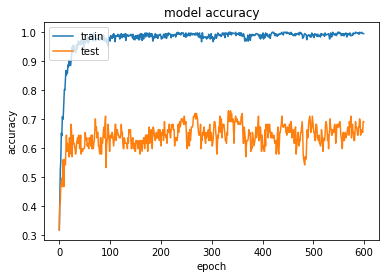

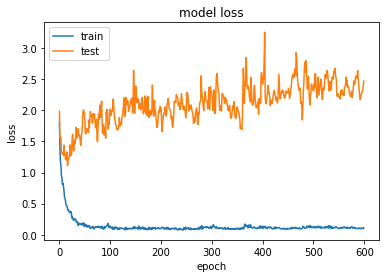

In [52]:
#Evaluate the model with the test dataset
score, acc = model.evaluate(X_test, Y_test, batch_size=5)
print('Test score:', score)
print('Test accuracy:', acc)

# summarize history for accuracy
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

As we can see, the accuracy is improved to 69%. But the gap between the training accuracy and the test accuracy is very large, which means the model is overfitting. The reason may be the dataset is too small, or the model is too complex. We also found the validation loss increased a little bit after 100 epochs, maybe we should stop at 100 epochs to reduce overfitting

## Set epochs to 100 and re-train the Model

In [43]:
np_seed = 10
tf_seed = 10
np.random.seed(np_seed)
set_random_seed(tf_seed)
model = build_model2(input_shape, num_classes)
model.summary()
#model.fit(X_train, Y_train, epochs=100, batch_size=40, validation_data = (X_test, Y_test), verbose=2)

batch_size = 40
epochs = 100

datagen = ImageDataGenerator(
        zoom_range=0.3, # randomly zoom into images
        #rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        #width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        #height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        #shear_range = 0.2,
        zca_whitening=True,
        #fill_mode = 'nearest',
        #horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

# Fit the model on the batches generated by datagen.flow().
#callback = EarlyStopping(monitor="loss", patience=100, verbose=1, mode="auto")

history2 = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                              steps_per_epoch=int(np.ceil(X_train.shape[0] / float(batch_size))),
                              epochs=epochs,
                              use_multiprocessing = False,
                              workers=4, validation_data = (X_test, Y_test), verbose=2)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 73, 73, 16)        160       
_________________________________________________________________
batch_normalization_49 (Batc (None, 73, 73, 16)        64        
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 36, 36, 16)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 34, 34, 32)        4640      
_________________________________________________________________
batch_normalization_50 (Batc (None, 34, 34, 32)        128       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 17, 17, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 15, 15, 64)        18496     
__________

F:\Anaconda3\envs\tensorflow\lib\site-packages\keras_preprocessing\image.py:836: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100


F:\Anaconda3\envs\tensorflow\lib\site-packages\keras_preprocessing\image.py:1131: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
F:\Anaconda3\envs\tensorflow\lib\site-packages\keras_preprocessing\image.py:1150: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 - 4s - loss: 1.8127 - acc: 0.3393 - val_loss: 2.1942 - val_acc: 0.3271
Epoch 2/100
 - 0s - loss: 1.4551 - acc: 0.3805 - val_loss: 1.7906 - val_acc: 0.4206
Epoch 3/100
 - 0s - loss: 1.2116 - acc: 0.4874 - val_loss: 1.7483 - val_acc: 0.4112
Epoch 4/100
 - 0s - loss: 1.1103 - acc: 0.5312 - val_loss: 1.7386 - val_acc: 0.3738
Epoch 5/100
 - 0s - loss: 1.0252 - acc: 0.6076 - val_loss: 1.4460 - val_acc: 0.4579
Epoch 6/100
 - 0s - loss: 0.9679 - acc: 0.6238 - val_loss: 1.4300 - val_acc: 0.5140
Epoch 7/100
 - 0s - loss: 0.8577 - acc: 0.6982 - val_loss: 1.3598 - val_acc: 0.5234
Epoch 8/100
 - 0s - loss: 0.7625 - acc: 0.7268 - val_loss: 1.3275 - val_acc: 0.5514
Epoch 9/100
 - 0s - loss: 0.7163 - acc: 0.7608 - val_loss: 1.3101 - val_acc: 0.4953
Epoch 10/100
 - 0s - loss: 0.7065 - acc: 0.7517 - val_loss: 1.3546 - val_acc: 0.4953
Epoch 11/100
 - 0s - loss: 0.6222 - acc: 0.8046 - val_loss: 1.2764 - val_acc: 0.5701
Epoch 12/100
 - 0s - loss: 0.5805 - acc: 0.8170 - val_loss: 1.1843 - val_acc: 0.6075
E

Epoch 98/100
 - 0s - loss: 0.0917 - acc: 0.9874 - val_loss: 1.7998 - val_acc: 0.6262
Epoch 99/100
 - 0s - loss: 0.0891 - acc: 0.9932 - val_loss: 1.5256 - val_acc: 0.7009
Epoch 100/100
 - 0s - loss: 0.0779 - acc: 0.9977 - val_loss: 1.5574 - val_acc: 0.7196


## Evaluate the model and plot the training history

107/107 [==============================] - 0s 1ms/step
Test score: 1.557368349736539
Test accuracy: 0.7196261786690382


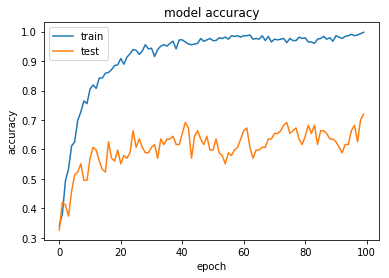

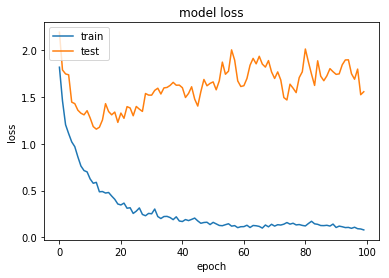

In [44]:
#Evaluate the model with the test dataset
score, acc = model.evaluate(X_test, Y_test, batch_size=5)
print('Test score:', score)
print('Test accuracy:', acc)

# summarize history for accuracy
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [45]:
#Save the model
model_json = model.to_json()
with open("G:\\machine_learning\\final_cnn_model1.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("G:\\machine_learning\\final_cnn_model1.h5")

In [46]:
# evaluate the model with the whole dataset
X, Y = load_data("G:\\machine_learning\\Final_Project_Dataset")
X = normalize_images(X)

X_x = X.reshape(X.shape[0], 75, 75, 1).astype('float32')
score, acc = model.evaluate(X_x, Y, batch_size=100)
print('Test score:', score)
print('Test accuracy:', acc)

532/532 [==============================] - 0s 156us/step
Test score: 0.3645110153838208
Test accuracy: 0.9417293080709931


## Try VGG to see if it can give us a better result. We import the pre-trained VGG model and add our own dense layers on it.  

In [13]:
from keras import applications
img_width = 75
img_height = 75

X_train = np.dstack([X_train] * 3)
X_test = np.dstack([X_test] * 3)
X_train = X_train.reshape(X_train.shape[0], 75, 75, 3).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 75, 75, 3).astype('float32')
input_shape = X_train[0].shape
num_classes = Y_test.shape[1]
print(input_shape, num_classes)

model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))
model.summary()

(75, 75, 3) 4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75, 75, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 75, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 75, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 37, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 37, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 37, 37, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 18, 18, 128)       0      

In [32]:
from keras import optimizers
#We use the first 21 layers of weights of VGG19 model
for layer in model.layers[:21]:
    layer.trainable = False
    
#Adding custom layers
m = model.output
m = Flatten()(m)
m = BatchNormalization()(m)
m = Dropout(0.1)(m)
m = Dense(128, activation='relu')(m)
m = BatchNormalization()(m)
m = Dropout(0.1)(m)
m = Dense(50, activation='relu')(m)
m = BatchNormalization()(m)

predictions = Dense(num_classes, activation="softmax")(m)

# creating the final model 
model_vgg = Model(input = model.input, output = predictions)

# compile the model 
#model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])
model_vgg.compile(loss = "categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

datagen = ImageDataGenerator(
        zoom_range=0.3, # randomly zoom into images
        #rotation_range=40,  # randomly rotate images in the range (degrees, 0 to 180)
        #width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        #height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        #shear_range = 0.2,
        fill_mode = 'nearest',
        zca_whitening=True,
        #horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images



epochs = 1000
history2 = model_vgg.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                              steps_per_epoch=int(np.ceil(X_train.shape[0] / float(batch_size))),
                              epochs=epochs,
                              use_multiprocessing = False,validation_data = (X_test, Y_test),
                              workers=4)

F:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
F:\Anaconda3\envs\tensorflow\lib\site-packages\keras_preprocessing\image.py:836: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/1000


F:\Anaconda3\envs\tensorflow\lib\site-packages\keras_preprocessing\image.py:1131: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
F:\Anaconda3\envs\tensorflow\lib\site-packages\keras_preprocessing\image.py:1150: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


11/11 [==============================] - 3s 291ms/step - loss: 1.8276 - acc: 0.2471 - val_loss: 1.6246 - val_acc: 0.3084
Epoch 2/1000
11/11 [==============================] - 1s 78ms/step - loss: 1.4352 - acc: 0.3863 - val_loss: 1.5172 - val_acc: 0.3458
Epoch 3/1000
11/11 [==============================] - 1s 78ms/step - loss: 1.2514 - acc: 0.4757 - val_loss: 1.4275 - val_acc: 0.4393
Epoch 4/1000
11/11 [==============================] - 1s 78ms/step - loss: 1.1700 - acc: 0.4704 - val_loss: 1.3216 - val_acc: 0.4579
Epoch 5/1000
11/11 [==============================] - 1s 78ms/step - loss: 1.1167 - acc: 0.5040 - val_loss: 1.2745 - val_acc: 0.5327
Epoch 6/1000
11/11 [==============================] - 1s 77ms/step - loss: 1.1094 - acc: 0.5101 - val_loss: 1.3013 - val_acc: 0.4673
Epoch 7/1000
11/11 [==============================] - 1s 79ms/step - loss: 1.0266 - acc: 0.5813 - val_loss: 1.2681 - val_acc: 0.4953
Epoch 8/1000
11/11 [==============================] - 1s 77ms/step - loss: 1.0022

11/11 [==============================] - 1s 79ms/step - loss: 0.2201 - acc: 0.9235 - val_loss: 1.8866 - val_acc: 0.5140
Epoch 124/1000
11/11 [==============================] - 1s 79ms/step - loss: 0.2263 - acc: 0.9132 - val_loss: 1.8421 - val_acc: 0.5140
Epoch 125/1000
11/11 [==============================] - 1s 78ms/step - loss: 0.2374 - acc: 0.9165 - val_loss: 1.8557 - val_acc: 0.5421
Epoch 126/1000
11/11 [==============================] - 1s 78ms/step - loss: 0.1929 - acc: 0.9372 - val_loss: 1.8476 - val_acc: 0.5421
Epoch 127/1000
11/11 [==============================] - 1s 78ms/step - loss: 0.1941 - acc: 0.9326 - val_loss: 1.8863 - val_acc: 0.5047
Epoch 128/1000
11/11 [==============================] - 1s 78ms/step - loss: 0.2508 - acc: 0.8982 - val_loss: 1.9299 - val_acc: 0.5047
Epoch 129/1000
11/11 [==============================] - 1s 79ms/step - loss: 0.2494 - acc: 0.9024 - val_loss: 2.0669 - val_acc: 0.5047
Epoch 130/1000
11/11 [==============================] - 1s 79ms/step -

Epoch 184/1000
11/11 [==============================] - 1s 78ms/step - loss: 0.1583 - acc: 0.9509 - val_loss: 1.9974 - val_acc: 0.5607
Epoch 185/1000
11/11 [==============================] - 1s 78ms/step - loss: 0.1380 - acc: 0.9658 - val_loss: 1.9134 - val_acc: 0.5701
Epoch 186/1000
11/11 [==============================] - 1s 78ms/step - loss: 0.2085 - acc: 0.9268 - val_loss: 1.9326 - val_acc: 0.5327
Epoch 187/1000
11/11 [==============================] - 1s 79ms/step - loss: 0.1622 - acc: 0.9496 - val_loss: 2.0249 - val_acc: 0.5421
Epoch 188/1000
11/11 [==============================] - 1s 78ms/step - loss: 0.2091 - acc: 0.9188 - val_loss: 2.0400 - val_acc: 0.5607
Epoch 189/1000
11/11 [==============================] - 1s 78ms/step - loss: 0.1492 - acc: 0.9476 - val_loss: 1.9580 - val_acc: 0.5327
Epoch 190/1000
11/11 [==============================] - 1s 78ms/step - loss: 0.1697 - acc: 0.9326 - val_loss: 2.0284 - val_acc: 0.5327
Epoch 191/1000
11/11 [==============================] -

Epoch 245/1000
11/11 [==============================] - 1s 78ms/step - loss: 0.1352 - acc: 0.9635 - val_loss: 1.9103 - val_acc: 0.5981
Epoch 246/1000
11/11 [==============================] - 1s 79ms/step - loss: 0.1384 - acc: 0.9496 - val_loss: 1.9644 - val_acc: 0.5701
Epoch 247/1000
11/11 [==============================] - 1s 79ms/step - loss: 0.1734 - acc: 0.9484 - val_loss: 2.0339 - val_acc: 0.5607
Epoch 248/1000
11/11 [==============================] - 1s 78ms/step - loss: 0.1527 - acc: 0.9428 - val_loss: 2.0672 - val_acc: 0.5701
Epoch 249/1000
11/11 [==============================] - 1s 78ms/step - loss: 0.1877 - acc: 0.9246 - val_loss: 2.0211 - val_acc: 0.5701
Epoch 250/1000
11/11 [==============================] - 1s 79ms/step - loss: 0.1566 - acc: 0.9463 - val_loss: 2.0566 - val_acc: 0.5981
Epoch 251/1000
11/11 [==============================] - 1s 78ms/step - loss: 0.1514 - acc: 0.9461 - val_loss: 2.1304 - val_acc: 0.5607
Epoch 252/1000
11/11 [==============================] -

Epoch 306/1000
11/11 [==============================] - 1s 82ms/step - loss: 0.1020 - acc: 0.9588 - val_loss: 2.4124 - val_acc: 0.4953
Epoch 307/1000
11/11 [==============================] - 1s 83ms/step - loss: 0.1545 - acc: 0.9461 - val_loss: 2.4127 - val_acc: 0.5140
Epoch 308/1000
11/11 [==============================] - 1s 82ms/step - loss: 0.1528 - acc: 0.9453 - val_loss: 2.3605 - val_acc: 0.5327
Epoch 309/1000
11/11 [==============================] - 1s 82ms/step - loss: 0.1858 - acc: 0.9314 - val_loss: 2.2709 - val_acc: 0.5140
Epoch 310/1000
11/11 [==============================] - 1s 83ms/step - loss: 0.1348 - acc: 0.9507 - val_loss: 2.2918 - val_acc: 0.4860
Epoch 311/1000
11/11 [==============================] - 1s 81ms/step - loss: 0.1346 - acc: 0.9519 - val_loss: 2.2771 - val_acc: 0.4953
Epoch 312/1000
11/11 [==============================] - 1s 82ms/step - loss: 0.1775 - acc: 0.9393 - val_loss: 2.2208 - val_acc: 0.5327
Epoch 313/1000
11/11 [==============================] -

Epoch 367/1000
11/11 [==============================] - 1s 78ms/step - loss: 0.1121 - acc: 0.9542 - val_loss: 2.2410 - val_acc: 0.5514
Epoch 368/1000
11/11 [==============================] - 1s 79ms/step - loss: 0.1466 - acc: 0.9459 - val_loss: 2.3180 - val_acc: 0.5234
Epoch 369/1000
11/11 [==============================] - 1s 79ms/step - loss: 0.1113 - acc: 0.9679 - val_loss: 2.2534 - val_acc: 0.5140
Epoch 370/1000
11/11 [==============================] - 1s 78ms/step - loss: 0.0723 - acc: 0.9726 - val_loss: 2.2764 - val_acc: 0.4766
Epoch 371/1000
11/11 [==============================] - 1s 79ms/step - loss: 0.0650 - acc: 0.9815 - val_loss: 2.2831 - val_acc: 0.5047
Epoch 372/1000
11/11 [==============================] - 1s 78ms/step - loss: 0.0970 - acc: 0.9704 - val_loss: 2.2342 - val_acc: 0.5421
Epoch 373/1000
11/11 [==============================] - 1s 79ms/step - loss: 0.1039 - acc: 0.9656 - val_loss: 2.2030 - val_acc: 0.5514
Epoch 374/1000
11/11 [==============================] -

Epoch 428/1000
11/11 [==============================] - 1s 82ms/step - loss: 0.1260 - acc: 0.9474 - val_loss: 2.1438 - val_acc: 0.5421
Epoch 429/1000
11/11 [==============================] - 1s 82ms/step - loss: 0.1165 - acc: 0.9610 - val_loss: 2.1675 - val_acc: 0.5327
Epoch 430/1000
11/11 [==============================] - 1s 80ms/step - loss: 0.0455 - acc: 0.9874 - val_loss: 2.1685 - val_acc: 0.5701
Epoch 431/1000
11/11 [==============================] - 1s 79ms/step - loss: 0.1111 - acc: 0.9691 - val_loss: 2.1807 - val_acc: 0.5888
Epoch 432/1000
11/11 [==============================] - 1s 80ms/step - loss: 0.0946 - acc: 0.9633 - val_loss: 2.1494 - val_acc: 0.5981
Epoch 433/1000
11/11 [==============================] - 1s 79ms/step - loss: 0.1506 - acc: 0.9552 - val_loss: 2.1176 - val_acc: 0.5794
Epoch 434/1000
11/11 [==============================] - 1s 79ms/step - loss: 0.0889 - acc: 0.9621 - val_loss: 2.0628 - val_acc: 0.5514
Epoch 435/1000
11/11 [==============================] -

Epoch 489/1000
11/11 [==============================] - 1s 79ms/step - loss: 0.0795 - acc: 0.9747 - val_loss: 2.5727 - val_acc: 0.4860
Epoch 490/1000
11/11 [==============================] - 1s 81ms/step - loss: 0.0715 - acc: 0.9793 - val_loss: 2.6202 - val_acc: 0.4766
Epoch 491/1000
11/11 [==============================] - 1s 81ms/step - loss: 0.1073 - acc: 0.9691 - val_loss: 2.6187 - val_acc: 0.4953
Epoch 492/1000
11/11 [==============================] - 1s 80ms/step - loss: 0.0633 - acc: 0.9818 - val_loss: 2.5259 - val_acc: 0.5234
Epoch 493/1000
11/11 [==============================] - 1s 80ms/step - loss: 0.1001 - acc: 0.9782 - val_loss: 2.4925 - val_acc: 0.5421
Epoch 494/1000
11/11 [==============================] - 1s 78ms/step - loss: 0.0636 - acc: 0.9795 - val_loss: 2.5163 - val_acc: 0.5140
Epoch 495/1000
11/11 [==============================] - 1s 79ms/step - loss: 0.1037 - acc: 0.9600 - val_loss: 2.5126 - val_acc: 0.5140
Epoch 496/1000
11/11 [==============================] -

Epoch 550/1000
11/11 [==============================] - 1s 78ms/step - loss: 0.0687 - acc: 0.9668 - val_loss: 2.4553 - val_acc: 0.5327
Epoch 551/1000
11/11 [==============================] - 1s 78ms/step - loss: 0.1015 - acc: 0.9681 - val_loss: 2.4254 - val_acc: 0.5421
Epoch 552/1000
11/11 [==============================] - 1s 83ms/step - loss: 0.0611 - acc: 0.9772 - val_loss: 2.4688 - val_acc: 0.4860
Epoch 553/1000
11/11 [==============================] - 1s 84ms/step - loss: 0.0919 - acc: 0.9623 - val_loss: 2.4380 - val_acc: 0.4860
Epoch 554/1000
11/11 [==============================] - 1s 84ms/step - loss: 0.1138 - acc: 0.9550 - val_loss: 2.4958 - val_acc: 0.4953
Epoch 555/1000
11/11 [==============================] - 1s 80ms/step - loss: 0.0786 - acc: 0.9656 - val_loss: 2.5762 - val_acc: 0.5047
Epoch 556/1000
11/11 [==============================] - 1s 78ms/step - loss: 0.1106 - acc: 0.9623 - val_loss: 2.7215 - val_acc: 0.4766
Epoch 557/1000
11/11 [==============================] -

Epoch 611/1000
11/11 [==============================] - 1s 78ms/step - loss: 0.0729 - acc: 0.9760 - val_loss: 2.6434 - val_acc: 0.5047
Epoch 612/1000
11/11 [==============================] - 1s 78ms/step - loss: 0.0946 - acc: 0.9631 - val_loss: 2.6476 - val_acc: 0.5234
Epoch 613/1000
11/11 [==============================] - 1s 78ms/step - loss: 0.1093 - acc: 0.9588 - val_loss: 2.7119 - val_acc: 0.5047
Epoch 614/1000
11/11 [==============================] - 1s 79ms/step - loss: 0.0836 - acc: 0.9600 - val_loss: 2.5975 - val_acc: 0.5047
Epoch 615/1000
11/11 [==============================] - 1s 79ms/step - loss: 0.1013 - acc: 0.9646 - val_loss: 2.4200 - val_acc: 0.5140
Epoch 616/1000
11/11 [==============================] - 1s 79ms/step - loss: 0.1156 - acc: 0.9621 - val_loss: 2.6044 - val_acc: 0.5140
Epoch 617/1000
11/11 [==============================] - 1s 78ms/step - loss: 0.1032 - acc: 0.9529 - val_loss: 2.7169 - val_acc: 0.4766
Epoch 618/1000
11/11 [==============================] -

Epoch 672/1000
11/11 [==============================] - 1s 79ms/step - loss: 0.0555 - acc: 0.9793 - val_loss: 2.5333 - val_acc: 0.4953
Epoch 673/1000
11/11 [==============================] - 1s 79ms/step - loss: 0.0890 - acc: 0.9714 - val_loss: 2.6269 - val_acc: 0.4766
Epoch 674/1000
11/11 [==============================] - 1s 79ms/step - loss: 0.0514 - acc: 0.9863 - val_loss: 2.7058 - val_acc: 0.4766
Epoch 675/1000
11/11 [==============================] - 1s 79ms/step - loss: 0.0857 - acc: 0.9726 - val_loss: 2.6007 - val_acc: 0.4953
Epoch 676/1000
11/11 [==============================] - 1s 81ms/step - loss: 0.0788 - acc: 0.9658 - val_loss: 2.4811 - val_acc: 0.5140
Epoch 677/1000
11/11 [==============================] - 1s 79ms/step - loss: 0.0782 - acc: 0.9668 - val_loss: 2.4916 - val_acc: 0.5047
Epoch 678/1000
11/11 [==============================] - 1s 79ms/step - loss: 0.0794 - acc: 0.9681 - val_loss: 2.6275 - val_acc: 0.5607
Epoch 679/1000
11/11 [==============================] -

Epoch 733/1000
11/11 [==============================] - 1s 79ms/step - loss: 0.0415 - acc: 0.9896 - val_loss: 2.5438 - val_acc: 0.5514
Epoch 734/1000
11/11 [==============================] - 1s 78ms/step - loss: 0.0781 - acc: 0.9724 - val_loss: 2.5108 - val_acc: 0.5047
Epoch 735/1000
11/11 [==============================] - 1s 79ms/step - loss: 0.0481 - acc: 0.9840 - val_loss: 2.4782 - val_acc: 0.5140
Epoch 736/1000
11/11 [==============================] - 1s 79ms/step - loss: 0.0553 - acc: 0.9782 - val_loss: 2.4306 - val_acc: 0.5607
Epoch 737/1000
11/11 [==============================] - 1s 79ms/step - loss: 0.0894 - acc: 0.9635 - val_loss: 2.4040 - val_acc: 0.5607
Epoch 738/1000
11/11 [==============================] - 1s 79ms/step - loss: 0.0806 - acc: 0.9635 - val_loss: 2.5039 - val_acc: 0.5607
Epoch 739/1000
11/11 [==============================] - 1s 79ms/step - loss: 0.0754 - acc: 0.9749 - val_loss: 2.5266 - val_acc: 0.5514
Epoch 740/1000
11/11 [==============================] -

Epoch 794/1000
11/11 [==============================] - 1s 78ms/step - loss: 0.0614 - acc: 0.9772 - val_loss: 2.6801 - val_acc: 0.5047
Epoch 795/1000
11/11 [==============================] - 1s 79ms/step - loss: 0.0739 - acc: 0.9726 - val_loss: 2.6778 - val_acc: 0.4860
Epoch 796/1000
11/11 [==============================] - 1s 80ms/step - loss: 0.0497 - acc: 0.9828 - val_loss: 2.6576 - val_acc: 0.5140
Epoch 797/1000
11/11 [==============================] - 1s 79ms/step - loss: 0.0532 - acc: 0.9840 - val_loss: 2.6125 - val_acc: 0.5047
Epoch 798/1000
11/11 [==============================] - 1s 78ms/step - loss: 0.0302 - acc: 0.9954 - val_loss: 2.6314 - val_acc: 0.5047
Epoch 799/1000
11/11 [==============================] - 1s 79ms/step - loss: 0.0628 - acc: 0.9772 - val_loss: 2.6125 - val_acc: 0.4953
Epoch 800/1000
11/11 [==============================] - 1s 79ms/step - loss: 0.1059 - acc: 0.9749 - val_loss: 2.5462 - val_acc: 0.5140
Epoch 801/1000
11/11 [==============================] -

Epoch 855/1000
11/11 [==============================] - 1s 79ms/step - loss: 0.0292 - acc: 0.9932 - val_loss: 3.0031 - val_acc: 0.4953
Epoch 856/1000
11/11 [==============================] - 1s 79ms/step - loss: 0.0575 - acc: 0.9757 - val_loss: 2.9685 - val_acc: 0.4860
Epoch 857/1000
11/11 [==============================] - 1s 78ms/step - loss: 0.0895 - acc: 0.9658 - val_loss: 2.8523 - val_acc: 0.4953
Epoch 858/1000
11/11 [==============================] - 1s 79ms/step - loss: 0.0613 - acc: 0.9793 - val_loss: 2.8441 - val_acc: 0.4953
Epoch 859/1000
11/11 [==============================] - 1s 79ms/step - loss: 0.0669 - acc: 0.9793 - val_loss: 2.8336 - val_acc: 0.5047
Epoch 860/1000
11/11 [==============================] - 1s 78ms/step - loss: 0.0676 - acc: 0.9714 - val_loss: 2.8162 - val_acc: 0.4766
Epoch 861/1000
11/11 [==============================] - 1s 78ms/step - loss: 0.0859 - acc: 0.9735 - val_loss: 2.8000 - val_acc: 0.5140
Epoch 862/1000
11/11 [==============================] -

Epoch 916/1000
11/11 [==============================] - 1s 78ms/step - loss: 0.0478 - acc: 0.9851 - val_loss: 2.6484 - val_acc: 0.5327
Epoch 917/1000
11/11 [==============================] - 1s 81ms/step - loss: 0.0450 - acc: 0.9909 - val_loss: 2.6874 - val_acc: 0.5047
Epoch 918/1000
11/11 [==============================] - 1s 80ms/step - loss: 0.0691 - acc: 0.9689 - val_loss: 2.6596 - val_acc: 0.5047
Epoch 919/1000
11/11 [==============================] - 1s 79ms/step - loss: 0.0730 - acc: 0.9782 - val_loss: 2.7134 - val_acc: 0.5047
Epoch 920/1000
11/11 [==============================] - 1s 79ms/step - loss: 0.0677 - acc: 0.9714 - val_loss: 2.7531 - val_acc: 0.4953
Epoch 921/1000
11/11 [==============================] - 1s 78ms/step - loss: 0.0714 - acc: 0.9726 - val_loss: 2.7490 - val_acc: 0.5047
Epoch 922/1000
11/11 [==============================] - 1s 79ms/step - loss: 0.0614 - acc: 0.9772 - val_loss: 2.7871 - val_acc: 0.5234
Epoch 923/1000
11/11 [==============================] -

Epoch 977/1000
11/11 [==============================] - 1s 81ms/step - loss: 0.0290 - acc: 0.9954 - val_loss: 2.6012 - val_acc: 0.5421
Epoch 978/1000
11/11 [==============================] - 1s 80ms/step - loss: 0.0301 - acc: 0.9863 - val_loss: 2.5770 - val_acc: 0.5234
Epoch 979/1000
11/11 [==============================] - 1s 81ms/step - loss: 0.0690 - acc: 0.9780 - val_loss: 2.6098 - val_acc: 0.5234
Epoch 980/1000
11/11 [==============================] - 1s 80ms/step - loss: 0.0557 - acc: 0.9805 - val_loss: 2.6046 - val_acc: 0.5421
Epoch 981/1000
11/11 [==============================] - 1s 81ms/step - loss: 0.0596 - acc: 0.9803 - val_loss: 2.6133 - val_acc: 0.5514
Epoch 982/1000
11/11 [==============================] - 1s 81ms/step - loss: 0.0373 - acc: 0.9840 - val_loss: 2.7553 - val_acc: 0.5514
Epoch 983/1000
11/11 [==============================] - 1s 80ms/step - loss: 0.0625 - acc: 0.9749 - val_loss: 2.8901 - val_acc: 0.4766
Epoch 984/1000
11/11 [==============================] -

In [33]:
score, acc = model_final.evaluate(X_test, Y_test, batch_size=100)
print('Test score:', score)
print('Test accuracy:', acc)

107/107 [==============================] - 1s 10ms/step
Test score: 1.4099377159760378
Test accuracy: 0.5233644698267785


The result is not good, we analyzed there might be two reasons:
1. VGG19 has too many parameters because it has 22 layers, but our dataset is too small, so it leads overfitting.
2. VGG pre-trained model is a very broad CNN model, which is not suitable for our dataset - figures regonization

## Data augmentation, just generate 5 images and save them to local disk to see what the  images look like.

D:\Anaconda3\lib\site-packages\keras_preprocessing\image.py:836: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '
D:\Anaconda3\lib\site-packages\keras_preprocessing\image.py:1131: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
D:\Anaconda3\lib\site-packages\keras_preprocessing\image.py:1150: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


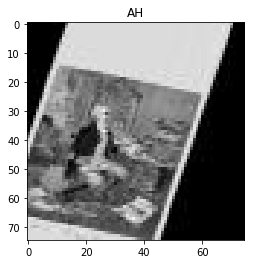

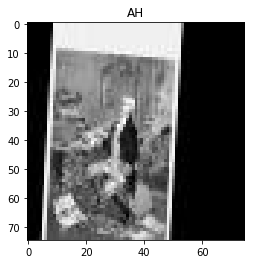

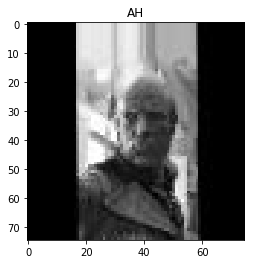

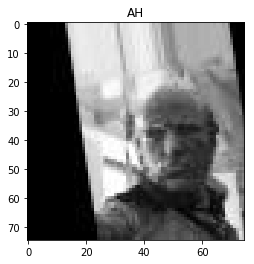

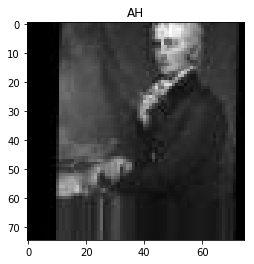

In [22]:
datagen = ImageDataGenerator(
        zoom_range=0.2, # randomly zoom into images
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        #shear_range = 0.2,
        fill_mode = 'nearest',
        zca_whitening=True,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

X, Y = load_data("F:\\study\\Neural_network\\homework\\Final_Project_Dataset")
X_reshape = X.reshape(X.shape[0], 75, 75, 1).astype('float32')
x = X_reshape[0:5]
i = 0
for batch in datagen.flow(x, batch_size = 5, save_to_dir='F:\\study\\Neural_network\\homework\\preview', save_prefix='people', save_format='jpg'):
    i = i+1
    break
    if i > 5:
        break

x, y = load_data("F:\\study\\Neural_network\\homework\\preview")

#plot 5 images and show the labels
show_image(x, y, 5)

After applying data augumentation, the images are generated to new images, which can give us more data to train

## Retrain our model with all dataset

In [47]:
X, Y = load_data("G:\\machine_learning\\Final_Project_Dataset")
X = normalize_images(X)

X_x = X.reshape(X.shape[0], 75, 75, 1).astype('float32')

np_seed = 10
tf_seed = 10
np.random.seed(np_seed)
set_random_seed(tf_seed)
input_shape = X_x[0].shape
num_classes = Y.shape[1]
print(input_shape)
model_final = build_model2(input_shape, num_classes)
model_final.summary()
#model.fit(X_train, Y_train, epochs=40, batch_size=40)


batch_size = 40
epochs = 100

datagen = ImageDataGenerator(
        zoom_range=0.3, # randomly zoom into images
        #rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        #width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        #height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        #shear_range = 0.2,
        zca_whitening=True,
        fill_mode = 'nearest',
        #horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

# Fit the model on the batches generated by datagen.flow().
history2 = model_final.fit_generator(datagen.flow(X_x, Y, batch_size=batch_size),
                              steps_per_epoch=int(np.ceil(X_x.shape[0] / float(batch_size))),
                              epochs=epochs,
                              use_multiprocessing = False,
                              workers=4, verbose=2)


(75, 75, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 73, 73, 16)        160       
_________________________________________________________________
batch_normalization_55 (Batc (None, 73, 73, 16)        64        
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 36, 36, 16)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 34, 34, 32)        4640      
_________________________________________________________________
batch_normalization_56 (Batc (None, 34, 34, 32)        128       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 17, 17, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 15, 15, 64)        18496    

F:\Anaconda3\envs\tensorflow\lib\site-packages\keras_preprocessing\image.py:836: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100


F:\Anaconda3\envs\tensorflow\lib\site-packages\keras_preprocessing\image.py:1131: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
F:\Anaconda3\envs\tensorflow\lib\site-packages\keras_preprocessing\image.py:1150: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 - 4s - loss: 1.8650 - acc: 0.2482
Epoch 2/100
 - 0s - loss: 1.3937 - acc: 0.4313
Epoch 3/100
 - 0s - loss: 1.2209 - acc: 0.4976
Epoch 4/100
 - 0s - loss: 1.0511 - acc: 0.5615
Epoch 5/100
 - 0s - loss: 0.9932 - acc: 0.6335
Epoch 6/100
 - 0s - loss: 0.9537 - acc: 0.6583
Epoch 7/100
 - 0s - loss: 0.8812 - acc: 0.6783
Epoch 8/100
 - 0s - loss: 0.8006 - acc: 0.7016
Epoch 9/100
 - 0s - loss: 0.7616 - acc: 0.7336
Epoch 10/100
 - 0s - loss: 0.7516 - acc: 0.7264
Epoch 11/100
 - 0s - loss: 0.6340 - acc: 0.8097
Epoch 12/100
 - 0s - loss: 0.6585 - acc: 0.7533
Epoch 13/100
 - 0s - loss: 0.6100 - acc: 0.8112
Epoch 14/100
 - 0s - loss: 0.5296 - acc: 0.8292
Epoch 15/100
 - 0s - loss: 0.5243 - acc: 0.8453
Epoch 16/100
 - 0s - loss: 0.5261 - acc: 0.8274
Epoch 17/100
 - 0s - loss: 0.4637 - acc: 0.8578
Epoch 18/100
 - 0s - loss: 0.4582 - acc: 0.8473
Epoch 19/100
 - 0s - loss: 0.5025 - acc: 0.8414
Epoch 20/100
 - 0s - loss: 0.4189 - acc: 0.8886
Epoch 21/100
 - 0s - loss: 0.4494 - acc: 0.8447
Epoch 22/100


## Save model and weights

In [48]:
model_json = model_final.to_json()
with open("G:\\machine_learning\\final_cnn_model.json", "w") as json_file:
    json_file.write(model_json)
    
# To save out the weights
model_final.save_weights("G:\\machine_learning\\final_cnn_model.h5")

## Load model

In [49]:
from keras.models import model_from_json

X, Y = load_data("G:\\machine_learning\\Final_Project_Dataset")
X = normalize_images(X)

X_x = X.reshape(X.shape[0], 75, 75, 1).astype('float32')

with open('G:\machine_learning\\final_cnn_model.json', 'r') as json_file:
    model_json = json_file.read()
    loaded_model = model_from_json(model_json)
    
# We can load any properly configured weights into any model we want
loaded_model.load_weights("G:\machine_learning\\final_cnn_model.h5")
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
score, acc = loaded_model.evaluate(X_x, Y, batch_size=100)
print('Test score:', score)
print('Test accuracy:', acc)

532/532 [==============================] - 2s 4ms/step
Test score: 0.07081833134468336
Test accuracy: 1.0


## Conlusion: We improve our CNN model accuracy by data augmentation, L2 regularization, batch normalization, and drop out